In [2]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Kraken API endpoint
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey={alphavantage_api_key}".format(alphavantage_api_key=os.getenv("ALPHAVANTAGE_API_KEY"))


In [4]:

# Make the API request
response = requests.get(url)
data = response.json()
print(data)  # Print the raw data for debugging

short_term_window = 5  # Short-term moving average window
long_term_window = 20  # Long-term moving average window


{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'MSFT', '3. Last Refreshed': '2025-03-14', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-03-14': {'1. open': '379.7750', '2. high': '390.2300', '3. low': '379.5100', '4. close': '388.5600', '5. volume': '19952846'}, '2025-03-13': {'1. open': '383.1550', '2. high': '385.3200', '3. low': '377.4500', '4. close': '378.7700', '5. volume': '20473017'}, '2025-03-12': {'1. open': '382.9500', '2. high': '385.2165', '3. low': '378.9507', '4. close': '383.2700', '5. volume': '24253567'}, '2025-03-11': {'1. open': '379.0000', '2. high': '386.0000', '3. low': '376.9100', '4. close': '380.4500', '5. volume': '30380177'}, '2025-03-10': {'1. open': '385.8400', '2. high': '386.4000', '3. low': '377.2200', '4. close': '380.1600', '5. volume': '32569768'}, '2025-03-07': {'1. open': '392.3200', '2. high': '394.8000', '3. low': '385.5400', '4. close': '393.3100', 

In [5]:
def CreateDF(data):
    # Convert the JSON data to a DataFrame
    df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
    # Rename the columns to remove the prefix
    df.columns = [col.split(' ')[1] for col in df.columns]
    # Rename the index to 'Date'
    df.index.name = 'Date'
    df.index = pd.to_datetime(df.index)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.sort_index(inplace=True)
    return df



dateframe = CreateDF(data)
print(dateframe)

               open      high       low   close    volume
Date                                                     
1999-11-01   93.250   94.1900   92.1200   92.37  26630600
1999-11-02   92.750   94.5000   91.9400   92.56  23174500
1999-11-03   92.940   93.5000   91.5000   92.00  22258500
1999-11-04   92.310   92.7500   90.3100   91.75  27119700
1999-11-05   91.810   92.8700   90.5000   91.56  35083700
...             ...       ...       ...     ...       ...
2025-03-10  385.840  386.4000  377.2200  380.16  32569768
2025-03-11  379.000  386.0000  376.9100  380.45  30380177
2025-03-12  382.950  385.2165  378.9507  383.27  24253567
2025-03-13  383.155  385.3200  377.4500  378.77  20473017
2025-03-14  379.775  390.2300  379.5100  388.56  19952846

[6381 rows x 5 columns]


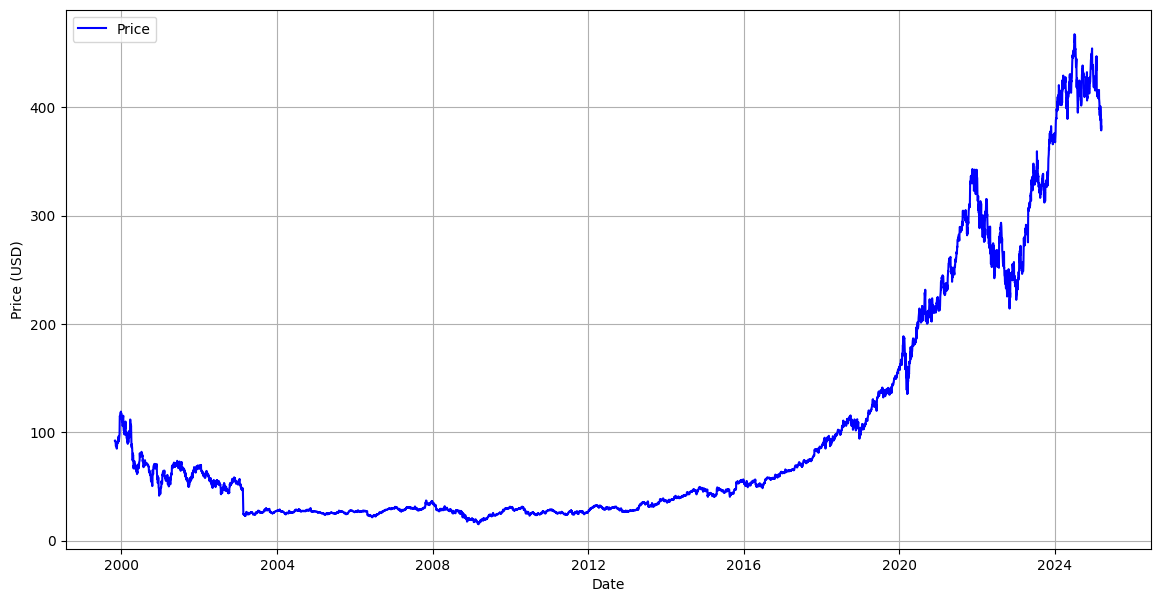

In [6]:
def graph_data(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Price', color='blue')    
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

graph_data(dateframe)

In [7]:
def calculate_ema(df, window):
    return df['close'].ewm(span=window, adjust=False).mean()

short_momentum = calculate_ema(dateframe, short_term_window)
long_momentum = calculate_ema(dateframe, long_term_window)

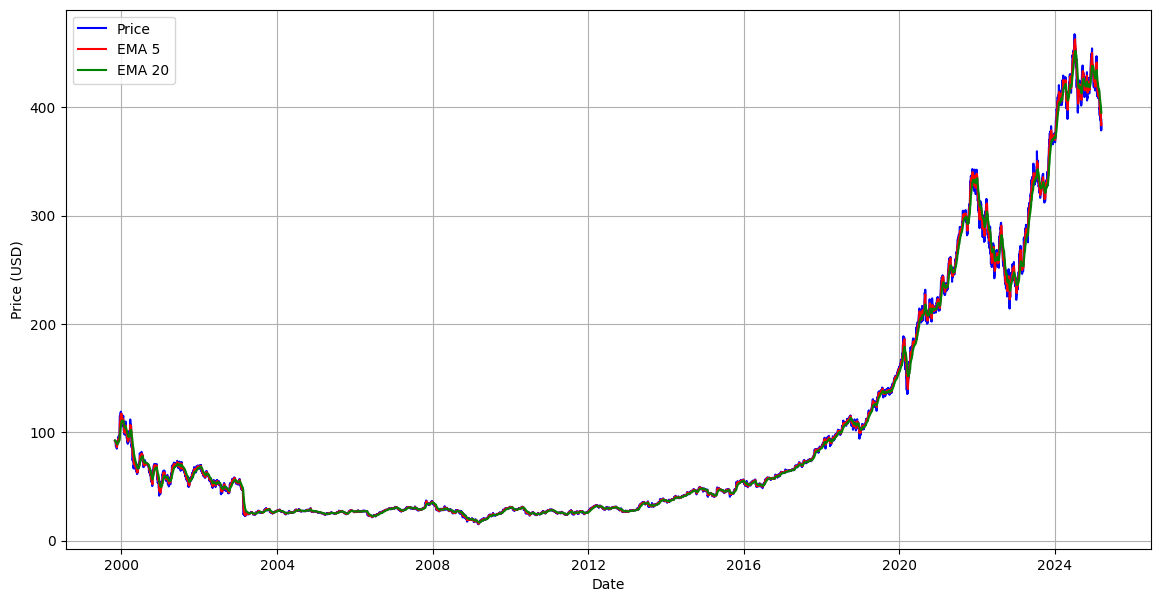

In [8]:
def plot_ema(df, short_momentum, long_momentum):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Price', color='blue')
    plt.plot(df.index, short_momentum, label=f'EMA {short_term_window}', color='red')
    plt.plot(df.index, long_momentum, label=f'EMA {long_term_window}', color='green')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

plot_ema(dateframe, short_momentum, long_momentum)

In [9]:
initial_balance = 100  # Starting balance in USD
btc_balance = 0
position = False
buy_price = 0
trade_log = []

def simulate_trading(df, short_momentum, long_momentum):
    global initial_balance, btc_balance, position, buy_price

    for i in range(1, len(df)):
        # Check for BUY signal
        if short_momentum.iloc[i] > long_momentum.iloc[i] and short_momentum.iloc[i - 1] <= long_momentum.iloc[i - 1]:
            if not position:
                # BUY action
                buy_price = df['close'].iloc[i]
                btc_balance = initial_balance / buy_price
                initial_balance = 0
                position = True
                trade_log.append({
                    'Date': df.index[i],
                    'Action': 'BUY',
                    'Price': buy_price,
                    'BTC Balance': btc_balance,
                    'USD Balance': initial_balance
                })
                print(f"BUY at {buy_price:.2f} on {df.index[i].date()}")

        # Check for SELL signal
        elif short_momentum.iloc[i] < long_momentum.iloc[i] and short_momentum.iloc[i - 1] >= long_momentum.iloc[i - 1]:
            if position:
                # SELL action
                sell_price = df['close'].iloc[i]
                initial_balance = btc_balance * sell_price
                btc_balance = 0
                position = False
                trade_log.append({
                    'Date': df.index[i],
                    'Action': 'SELL',
                    'Price': sell_price,
                    'BTC Balance': btc_balance,
                    'USD Balance': initial_balance
                })
                print(f"SELL at {sell_price:.2f} on {df.index[i].date()}")

    # Final value if holding BTC
    if position:
        final_price = df['close'].iloc[-1]
        initial_balance = btc_balance * final_price
        trade_log.append({
            'Date': df.index[-1],
            'Action': 'FINAL SELL',
            'Price': final_price,
            'BTC Balance': 0,
            'USD Balance': initial_balance
        })
        print(f"FINAL SELL at {final_price:.2f} on {df.index[-1].date()}")

simulate_trading(dateframe, short_momentum, long_momentum)

BUY at 92.56 on 1999-11-02
SELL at 92.00 on 1999-11-03
BUY at 91.12 on 1999-11-26
SELL at 105.81 on 2000-01-12
BUY at 115.31 on 2000-01-18
SELL at 107.00 on 2000-01-19
BUY at 109.94 on 2000-02-08
SELL at 99.94 on 2000-02-11
BUY at 101.00 on 2000-03-10
SELL at 95.37 on 2000-03-15
BUY at 99.37 on 2000-03-17
SELL at 90.87 on 2000-04-03
BUY at 70.50 on 2000-06-07
SELL at 73.12 on 2000-07-19
BUY at 72.62 on 2000-08-10
SELL at 72.19 on 2000-08-14
BUY at 65.19 on 2000-10-20
SELL at 65.06 on 2000-11-29
BUY at 52.88 on 2001-01-10
SELL at 58.38 on 2001-02-14
BUY at 59.36 on 2001-03-01
SELL at 56.69 on 2001-03-02
BUY at 60.69 on 2001-03-07
SELL at 56.69 on 2001-03-09
BUY at 58.25 on 2001-03-27
SELL at 55.38 on 2001-03-29
BUY at 57.15 on 2001-04-09
SELL at 68.02 on 2001-06-15
BUY at 71.14 on 2001-06-27
SELL at 68.51 on 2001-07-05
BUY at 71.34 on 2001-07-13
SELL at 67.09 on 2001-07-23
BUY at 57.72 on 2001-10-05
SELL at 66.10 on 2002-01-18
BUY at 63.30 on 2002-03-04
SELL at 60.10 on 2002-03-20
BUY a

In [10]:
trade_log_df = pd.DataFrame(trade_log)
print(trade_log_df)

          Date Action   Price  BTC Balance  USD Balance
0   1999-11-02    BUY   92.56     1.080380     0.000000
1   1999-11-03   SELL   92.00     0.000000    99.394987
2   1999-11-26    BUY   91.12     1.090814     0.000000
3   2000-01-12   SELL  105.81     0.000000   115.419047
4   2000-01-18    BUY  115.31     1.000946     0.000000
..         ...    ...     ...          ...          ...
403 2024-11-18   SELL  415.76     0.000000   171.421483
404 2024-11-26    BUY  427.99     0.400527     0.000000
405 2024-12-27   SELL  430.53     0.000000   172.438821
406 2025-01-22    BUY  446.20     0.386461     0.000000
407 2025-01-31   SELL  415.06     0.000000   160.404431

[408 rows x 5 columns]


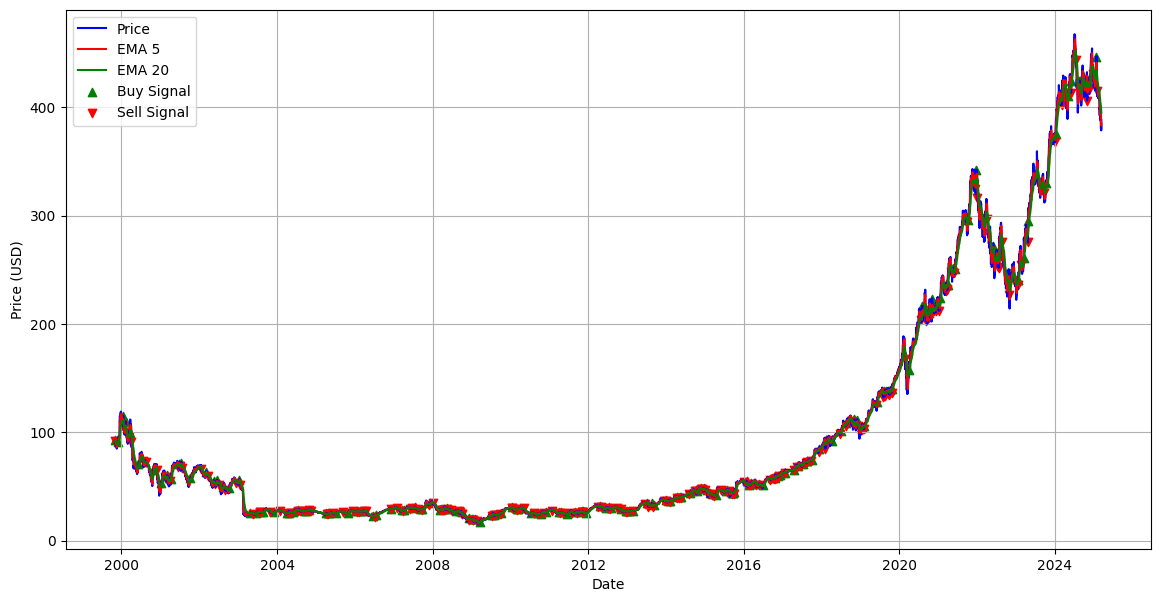

In [11]:
def plot_trades(df, short_momentum, long_momentum, trades):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Price', color='blue')
    plt.plot(df.index, short_momentum, label=f'EMA {short_term_window}', color='red')
    plt.plot(df.index, long_momentum, label=f'EMA {long_term_window}', color='green')

    # Plot Buy signals
    buys = trades[trades['Action'] == 'BUY']
    plt.scatter(buys['Date'], buys['Price'], marker='^', color='green', label='Buy Signal', alpha=1)

    # Plot Sell signals
    sells = trades[trades['Action'] == 'SELL']
    plt.scatter(sells['Date'], sells['Price'], marker='v', color='red', label='Sell Signal', alpha=1)

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

# Plot trades
plot_trades(dateframe, short_momentum, long_momentum, trade_log_df)

In [12]:
initial_value = 100
final_value = initial_balance
profit = final_value - initial_value
roi = (profit / initial_value) * 100

print(f"Initial Balance: ${initial_value:.2f}")
print(f"Final Balance: ${final_value:.2f}")
print(f"Profit: ${profit:.2f}")
print(f"ROI: {roi:.2f}%")

Initial Balance: $100.00
Final Balance: $160.40
Profit: $60.40
ROI: 60.40%
